In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [ ]:
# # CUDA 11.1
# !pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0

In [ ]:
# RMSE -> MAE Loss 꿀팁!!

In [2]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/utils'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/module'))

from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Thu Jul 15 05:13:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:18:00.0 Off |                  N/A |
| 97%   88C    P2   277W / 280W |  21188MiB / 24220MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:3B:00.0 Off |                  N/A |
|100%   

## Setup imports

In [4]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    RandFlipd,
    Lambdad,
    ToTensord,
    CastToTyped,
    DeleteItemsd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    RandSpatialCropd,
    Resized,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.15.0-134-generic)
Numpy version: 1.18.5
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.51.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [3]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Train / Test

In [5]:
test_low_images      = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Train/*/20/*/*/*.npy'))
test_high_images     = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Train/*/X/*/*/*.npy'))

dcm_test_low_images  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Train/*/20/*/*/*.dcm'))
dcm_test_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Train/*/X/*/*/*.dcm'))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(test_low_images,
                                                                                                                                              test_high_images, 
                                                                                                                                              dcm_test_low_images, 
                                                                                                                                              dcm_test_high_images)]

## Augmentation

In [6]:
def MinMax_Normalize(x):
    x -= x.min()
    x /= x.max()
    return x

In [7]:
# CT에 맞는 Augmentation
from torchvision import transforms
test_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
        ToTensord(keys=["low", "high"]),
    ]
)

## Check transforms in DataLoader

In [32]:
def visual_windowing_V2(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

image shape: torch.Size([512, 512])


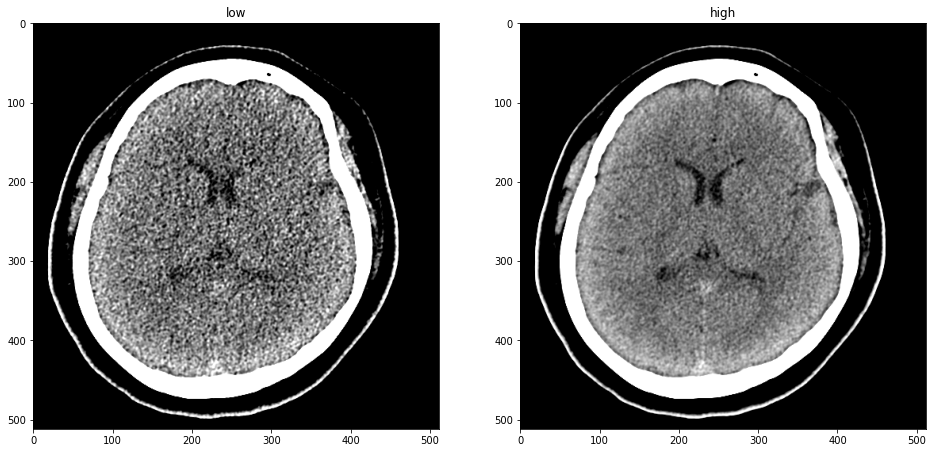

In [9]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[142]

n_20 = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {n_20.shape}")

plt.figure("check", (16, 12))

plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing_V2(n_20), cmap="gray")


plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing_V2(high), cmap="gray")

plt.show()

## DataLoader

In [10]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8, drop_last=False)

CPU 갯수 =  32


## Create Model, Loss, Optimizer  Only Low -> High

In [11]:
from utils.Unet_sunggu.model import Enhance_hidden_UNet_V2

class Seqeunce_UNet(torch.nn.Module):
    def __init__(self):
        super(Seqeunce_UNet, self).__init__()        
        self.unet = Enhance_hidden_UNet_V2(input_nc=1, output_nc=1)

#     def inference(self, noise_20, noise_40, noise_60, noise_80):
#         # noise 20이 noise 40보다 더 noise가 심함.
#         pred_noise_40, feat_n_40 = self.unet(noise_20, None)
#         pred_noise_60, feat_n_60 = self.unet(noise_40, feat_n_40)
#         pred_noise_80, feat_n_80 = self.unet(noise_60, feat_n_60)
#         pred_high,     feat_high = self.unet(noise_80, feat_n_80)
        
#         return pred_noise_40, pred_noise_60, pred_noise_80, pred_high

    def forward(self, noise_20):
        # noise 20이 noise 40보다 더 noise가 심함.
        pred_noise_40, feat_n_40 = self.unet(noise_20, [None, None, None, None, None])
        pred_noise_60, feat_n_60 = self.unet(pred_noise_40, feat_n_40)
        pred_noise_80, feat_n_80 = self.unet(pred_noise_60, feat_n_60)
        pred_high,     feat_high = self.unet(pred_noise_80, feat_n_80)
        
        return pred_noise_40, pred_noise_60, pred_noise_80, pred_high
    
device = 'cuda'
model  = Seqeunce_UNet()      

## 모델 이어서 학습하기

In [12]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/[Sequence_SkipHidden_Unet]Dose Unet_No_teacher/epoch_60_model.pth'
checkpoint = torch.load(checkpoint_dir)

model.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch']
print(epoch)
model.to('cuda')

60


Seqeunce_UNet(
  (unet): Enhance_hidden_UNet_V2(
    (enc1_1): CBR2d(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (enc1_2): CBR2d(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool1): DownsampleBlock(
      (downsample): Sequential(
        (0): PixelUnshuffle(downscale_factor=2)
        (1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (enc2_1): CBR2d(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (enc2_2): CBR2d(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNor

## TEST

In [13]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy        = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm_window  = visual_windowing_V2

In [14]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x): # pydicom에 자동으로 -1024를 해주는 부분이 있어서?
    x = (4095.0)*x
    return x

In [15]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

Test:   0%|          | 0/6054 [00:00<?, ?it/s]

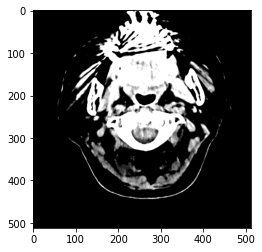

Test:   0%|          | 1/6054 [00:01<1:55:17,  1.14s/it]

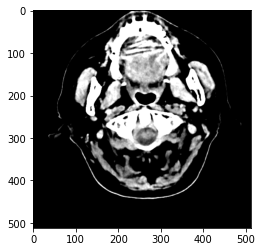

Test:   0%|          | 2/6054 [00:01<1:37:59,  1.03it/s]

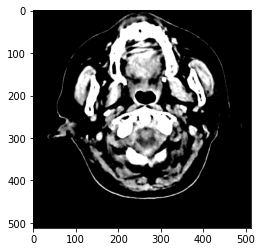

Test:   0%|          | 3/6054 [00:02<1:24:38,  1.19it/s]

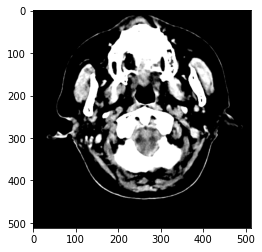

Test:   0%|          | 4/6054 [00:02<1:15:25,  1.34it/s]

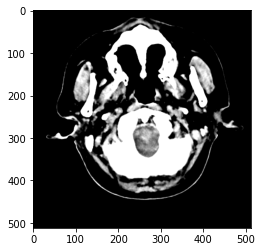

Test:   0%|          | 5/6054 [00:03<1:09:32,  1.45it/s]

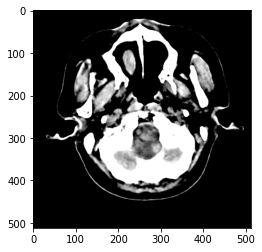

Test:   0%|          | 6/6054 [00:03<1:04:33,  1.56it/s]

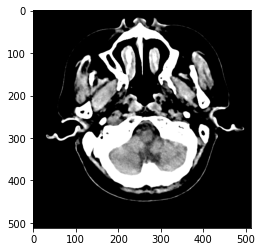

Test:   0%|          | 7/6054 [00:04<1:01:30,  1.64it/s]

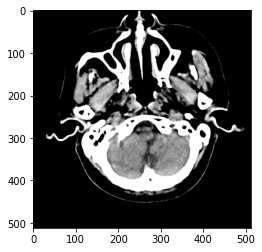

Test:   0%|          | 8/6054 [00:04<59:26,  1.70it/s]  

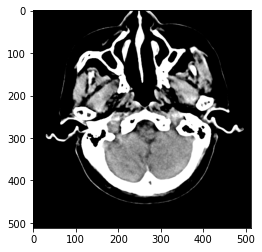

Test:   0%|          | 9/6054 [00:05<58:15,  1.73it/s]

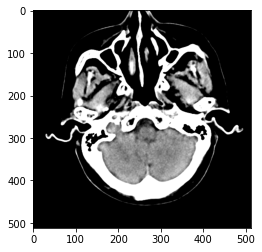

Test:   0%|          | 10/6054 [00:06<57:33,  1.75it/s]

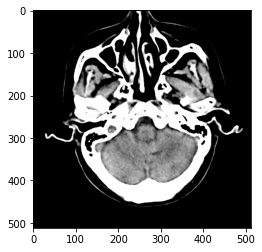

Test:   0%|          | 11/6054 [00:06<56:40,  1.78it/s]

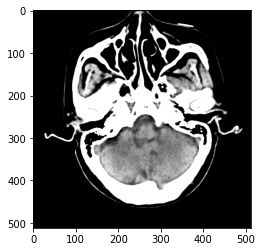

Test:   0%|          | 12/6054 [00:07<55:49,  1.80it/s]

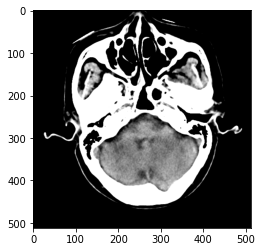

Test:   0%|          | 13/6054 [00:07<55:10,  1.82it/s]

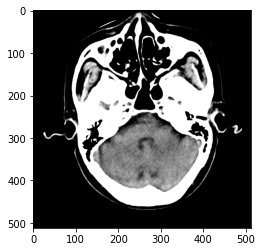

Test:   0%|          | 14/6054 [00:08<54:57,  1.83it/s]

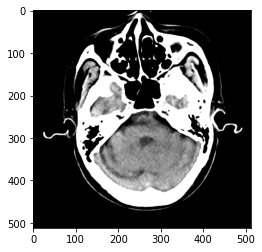

Test:   0%|          | 15/6054 [00:08<55:03,  1.83it/s]

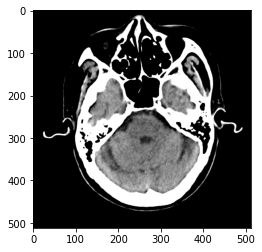

Test:   0%|          | 16/6054 [00:09<55:06,  1.83it/s]

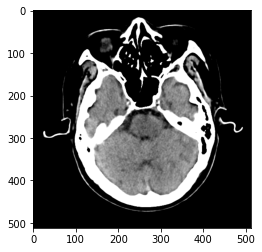

Test:   0%|          | 17/6054 [00:09<55:19,  1.82it/s]

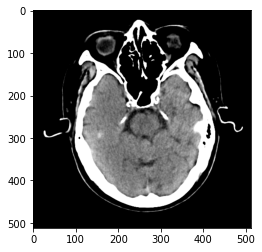

Test:   0%|          | 18/6054 [00:10<1:00:05,  1.67it/s]

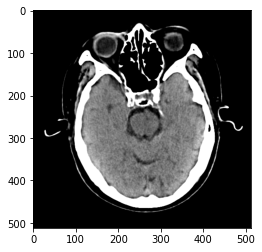

Test:   0%|          | 19/6054 [00:11<59:36,  1.69it/s]  

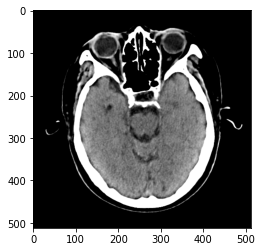

Test:   0%|          | 20/6054 [00:11<59:44,  1.68it/s]

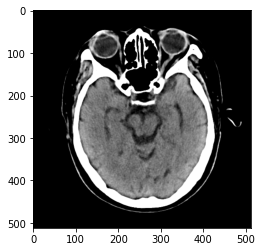

Test:   0%|          | 21/6054 [00:12<59:24,  1.69it/s]

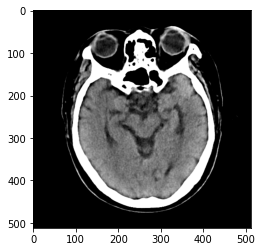

Test:   0%|          | 22/6054 [00:12<59:06,  1.70it/s]

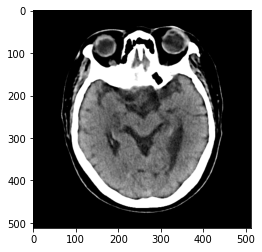

Test:   0%|          | 23/6054 [00:13<59:08,  1.70it/s]

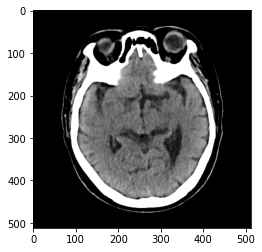

Test:   0%|          | 24/6054 [00:14<59:26,  1.69it/s]

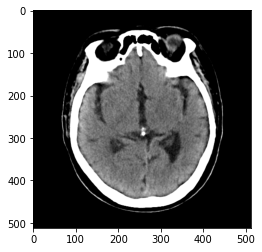

Test:   0%|          | 25/6054 [00:14<1:00:06,  1.67it/s]

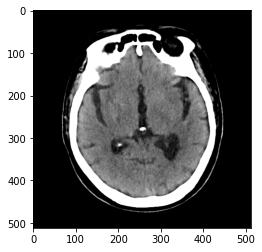

Test:   0%|          | 26/6054 [00:15<1:00:03,  1.67it/s]

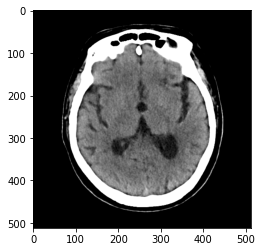

Test:   0%|          | 27/6054 [00:15<1:00:15,  1.67it/s]

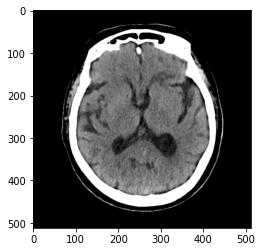

Test:   0%|          | 28/6054 [00:16<1:00:15,  1.67it/s]

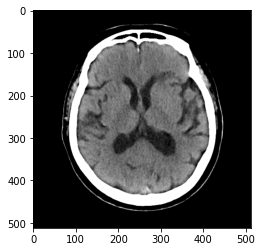

Test:   0%|          | 29/6054 [00:17<1:00:04,  1.67it/s]

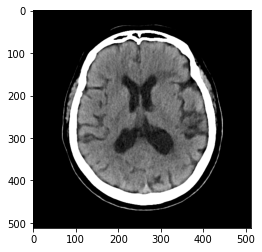

Test:   0%|          | 30/6054 [00:17<1:00:02,  1.67it/s]

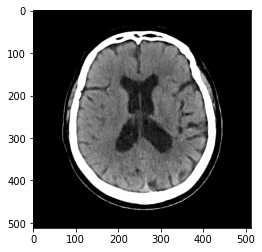

Test:   1%|          | 31/6054 [00:18<1:00:05,  1.67it/s]

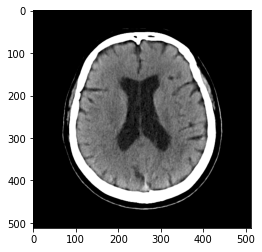

Test:   1%|          | 32/6054 [00:18<1:00:27,  1.66it/s]

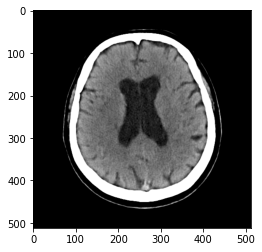

Test:   1%|          | 33/6054 [00:19<1:00:06,  1.67it/s]

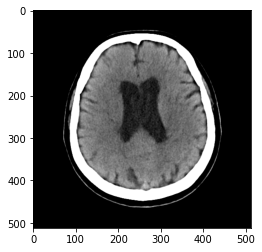

Test:   1%|          | 34/6054 [00:20<59:38,  1.68it/s]  

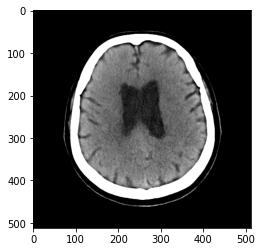

Test:   1%|          | 35/6054 [00:20<59:44,  1.68it/s]

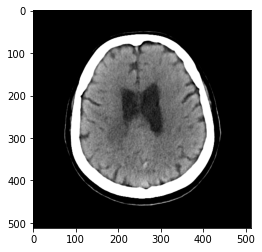

Test:   1%|          | 36/6054 [00:21<59:15,  1.69it/s]


KeyboardInterrupt: 

In [66]:
# test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Sequence_Skip_Unet_no_teacher_epoch_'+str(epoch) + '/low2high/'
# test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/test_Sequence_Skip_Unet_no_teacher_epoch_'+str(epoch) + '/low2high/'


test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/gg'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/gg'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    model.train()
#     model.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[7], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[7], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        pred_noise_40, pred_noise_60, pred_noise_80, pred_high = model(input_low)

#         # DCM Save
#         input_low_dcm       = fn_tonumpy(return_preprocessing_for_dcm(input_low))
#         input_high_dcm      = fn_tonumpy(return_preprocessing_for_dcm(input_high))
        
#         pred_noise_40_dcm   = fn_tonumpy(return_preprocessing_for_dcm(pred_noise_40))
#         pred_noise_60_dcm   = fn_tonumpy(return_preprocessing_for_dcm(pred_noise_60))
#         pred_noise_80_dcm   = fn_tonumpy(return_preprocessing_for_dcm(pred_noise_80))
#         pred_high_dcm       = fn_tonumpy(return_preprocessing_for_dcm(pred_high))

#         save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[7]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
#         save_dicom(batch_data['dcm_high'][0], input_high_dcm,  test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[7]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1])
        
#         save_dicom(batch_data['dcm_low'][0],  pred_noise_40_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[7]+'/pred_n_40_' +batch_data['dcm_low'][0].split('/')[-1])        
#         save_dicom(batch_data['dcm_low'][0],  pred_noise_60_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[7]+'/pred_n_60_' +batch_data['dcm_low'][0].split('/')[-1])        
#         save_dicom(batch_data['dcm_low'][0],  pred_noise_80_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[7]+'/pred_n_80_' +batch_data['dcm_low'][0].split('/')[-1])        
#         save_dicom(batch_data['dcm_low'][0],  pred_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[7]+'/pred_n_100_' +batch_data['dcm_low'][0].split('/')[-1])        
        
        # PNG Save
        input_low     = fn_denorm_window(fn_tonumpy((input_low)))
        input_high    = fn_denorm_window(fn_tonumpy((input_high)))        
        pred_noise_40 = fn_denorm_window(fn_tonumpy((pred_noise_40)))
        pred_noise_60 = fn_denorm_window(fn_tonumpy((pred_noise_60)))
        pred_noise_80 = fn_denorm_window(fn_tonumpy((pred_noise_80)))
        pred_high     = fn_denorm_window(fn_tonumpy((pred_high)))

        input_low       = np.clip(input_low,     a_min=0, a_max=1)
        input_high      = np.clip(input_high,    a_min=0, a_max=1)
        pred_noise_40   = np.clip(pred_noise_40, a_min=0, a_max=1)
        pred_noise_60   = np.clip(pred_noise_60, a_min=0, a_max=1)
        pred_noise_80   = np.clip(pred_noise_80, a_min=0, a_max=1)
        pred_high       = np.clip(pred_high,     a_min=0, a_max=1)
        
        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[7]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_low[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_high'][0].split('/')[7]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_high[0].squeeze(),   cmap="gray")
        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[7]+'/pred_n_40_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   pred_noise_40[0].squeeze(),   cmap="gray")        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[7]+'/pred_n_60_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   pred_noise_60[0].squeeze(),   cmap="gray")    
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[7]+'/pred_n_80_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   pred_noise_80[0].squeeze(),   cmap="gray")    
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[7]+'/pred_n_100_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   pred_high[0].squeeze(),   cmap="gray")   
        
        
        plt.imshow(pred_high[0].squeeze(), 'gray')
        plt.show()
                
                                     
          

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)

## GAN image Metric

### Pred dcm 경로

In [ ]:
# real_dcm_low_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*50/b40f/*/Brain*B40f_3.0*/*.dcm"))
# real_dcm_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*100/b40f/*/Brain*B40f_3.0*/*.dcm"))

In [ ]:
model_dir = "test_Unet_L1_epoch_995"
dcm_low_images   = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_low*.dcm"))
dcm_high_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_high*.dcm"))
pred_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/pred*.dcm"))


In [ ]:
def CT_12bit_processing(x):
    # H, W, D
    x[x < -1024.0] = -1024.0
    x[x > 3072.0] = 3072.0
    x = (x + 1024.0) / 4095.0
    
    return x

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

gt_tp_list   =[]
pred_tp_list =[]
input_tp_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    np_gt_H    = CT_12bit_processing(np_gt_H)
    np_pred_H  = CT_12bit_processing(np_pred_H)
    np_input_L = CT_12bit_processing(np_input_L)
    
    tp_gt_H   = torch.from_numpy(np_gt_H)
    tp_pred_H = torch.from_numpy(np_pred_H)  # 1, 512, 512
    tp_pred_L = torch.from_numpy(np_input_L)  # 1, 512, 512
    
    gt_tp_list.append(tp_gt_H)
    pred_tp_list.append(tp_pred_H)
    input_tp_list.append(tp_pred_L)
    
gt_zip    = torch.stack(gt_tp_list, dim=0)
pred_zip  = torch.stack(pred_tp_list, dim=0)
input_zip = torch.stack(input_tp_list, dim=0)


### SSIM

In [ ]:
# x: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).
# y: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).


In [ ]:
import piq

prediction  = pred_zip
target      = gt_zip
input       = input_zip

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(prediction, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss = piq.SSIMLoss(data_range=1.0)(prediction, target)
print(f"model SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(input, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss: torch.Tensor = piq.SSIMLoss(data_range=1.0)(input, target)
print(f"Input SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")


### PSNR

In [ ]:
import piq

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(prediction, target, data_range=1.0, reduction='none')
print(f"model PSNR index: {psnr_index.mean():0.4f}")

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(input, target, data_range=1.0, reduction='none')
print(f"Input PSNR index: {psnr_index.mean():0.4f}")

### 다시 PSNR 수정!

In [ ]:
def cal_PSNR(x):
    peak_pixel = x.max()
    patch_air  = x.squeeze()[30:60, 250:280]
    score = 10*np.log10( peak_pixel ** 2 / np.var(patch_air.flatten()))
    
    return score

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

gt_H_list   =[]
pred_H_list =[]
input_L_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    gt_H_list    = cal_PSNR(np_gt_H)
    pred_H_list  = cal_PSNR(np_pred_H)
    input_L_list = cal_PSNR(np_input_L)


In [ ]:
print(np.mean(gt_H_list))
print(np.mean(pred_H_list))
print(np.mean(input_L_list))

## MSE

In [ ]:
import math

def MSE(inputs, target):
    mse  = np.mean( (inputs - target) ** 2 )
    return mse

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

pred_high_mse_list   =[]
input_high_mse_list    =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))

    pred_high_mse    = MSE(np_gt_H, np_pred_H)
    input_high_mse   = MSE(np_gt_H, np_input_L)
    
    pred_high_mse_list.append(pred_high_mse)
    input_high_mse_list.append(input_high_mse)
    
print(f"Model MSE = {np.mean(pred_high_mse_list):0.4f}")
print()
print(f"Input MSE = {np.mean(input_high_mse_list):0.4f}")

## Difference Map

In [ ]:
i = 42
np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_images[i]))
np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_images[i]))
np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(dcm_low_images[i]))

In [ ]:
dcm_high_images[42]

In [ ]:
def pure_window(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    return x

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(131)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("Input Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(132)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Input High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")

plt.subplot(133)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Model High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/model_high_OT.png', pure_window(CT_12bit_processing(np_pred_H[0])),   cmap="gray")

plt.show()

### High vs Low

#### low-high(pred)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Low - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])) - pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Low - High(Pred)")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### high(pred) - low

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("High - Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("High(Pred) - Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### np.abs(high(pred) - low)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)

img1 = np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])))
img2 = np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])))

plt.imshow(img1, 'gray')
plt.title("np.abs(High - Low)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/gt1.png', img1,   cmap="gray")

plt.subplot(122)
plt.imshow(img2, 'gray')
plt.title("np.abs(High(Pred) - Low)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/pred1.png', img2,   cmap="gray")
plt.show()

### HIgh vs High

#### high-high(pred)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)

plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("High - High(Pred)")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### high(pred) - high

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High(Pred) - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### np.abs(high(pred) - high)

In [ ]:
plt.figure(figsize=(24, 12))
plt.subplot(121)

img1 = np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])))
img2 = np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])))


plt.imshow(np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0]))), 'gray')
plt.title("np.abs(High - High)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/gt1.png', img1,   cmap="gray")

plt.subplot(122)
plt.imshow(np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0]))), 'gray')
plt.title("np.abs(High(Pred) - High)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/pred1.png', img2,   cmap="gray")
plt.show()

# Follow dataset TEST

## Set Train / Test

In [ ]:
test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Low Dose Neck*/*.npy"))
test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Neck Other*/*.npy"))

dcm_test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Low Dose Neck*/*/*.dcm"))
dcm_test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Neck Other*/*/*.dcm"))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(test_low_images,
                                                                                  test_high_images, 
                                                                                  dcm_test_low_images, 
                                                                                  dcm_test_high_images)]

## Check transforms in DataLoader

In [ ]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[4]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")
print(low.max(), low.min(), low.dtype, low.shape)

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

In [ ]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=16, drop_last=False)

## TEST

In [ ]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm  = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [ ]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

In [ ]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

In [ ]:
test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/Follow_test_Unet_L1_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    model.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = model(input_low)

        # 저장하기
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_low[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

In [ ]:
## TEST

## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm  = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Unet_L1_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/test_Unet_L1_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    model.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = model(input_low)

        # 저장하기
#         print(input_low.min(), input_low.max())
#         input_low[:, 128:128+256, 128:128+256, :] = 0
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        input_high_dcm  = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_high)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_high'][0], input_high_dcm,  test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1])
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        input_high  = fn_denorm_window(fn_tonumpy((input_high)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        input_high  = np.clip(input_high, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_low[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_high[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          



def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)



## GAN image Metric

### Pred dcm 경로

# real_dcm_low_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*50/b40f/*/Brain*B40f_3.0*/*.dcm"))
# real_dcm_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*100/b40f/*/Brain*B40f_3.0*/*.dcm"))

model_dir = "test_Unet_L1_epoch_995"
dcm_low_images   = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_low*.dcm"))
dcm_high_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_high*.dcm"))
pred_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/pred*.dcm"))


def CT_12bit_processing(x):
    # H, W, D
    x[x < -1024.0] = -1024.0
    x[x > 3072.0] = 3072.0
    x = (x + 1024.0) / 4095.0
    
    return x

from pydicom import dcmread
import SimpleITK as sitk

gt_tp_list   =[]
pred_tp_list =[]
input_tp_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    np_gt_H    = CT_12bit_processing(np_gt_H)
    np_pred_H  = CT_12bit_processing(np_pred_H)
    np_input_L = CT_12bit_processing(np_input_L)
    
    tp_gt_H   = torch.from_numpy(np_gt_H)
    tp_pred_H = torch.from_numpy(np_pred_H)  # 1, 512, 512
    tp_pred_L = torch.from_numpy(np_input_L)  # 1, 512, 512
    
    gt_tp_list.append(tp_gt_H)
    pred_tp_list.append(tp_pred_H)
    input_tp_list.append(tp_pred_L)
    
gt_zip    = torch.stack(gt_tp_list, dim=0)
pred_zip  = torch.stack(pred_tp_list, dim=0)
input_zip = torch.stack(input_tp_list, dim=0)


### SSIM

# x: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).
# y: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).


import piq

prediction  = pred_zip
target      = gt_zip
input       = input_zip

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(prediction, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss = piq.SSIMLoss(data_range=1.0)(prediction, target)
print(f"model SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(input, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss: torch.Tensor = piq.SSIMLoss(data_range=1.0)(input, target)
print(f"Input SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")


### PSNR

import piq

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(prediction, target, data_range=1.0, reduction='none')
print(f"model PSNR index: {psnr_index.mean():0.4f}")

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(input, target, data_range=1.0, reduction='none')
print(f"Input PSNR index: {psnr_index.mean():0.4f}")

### 다시 PSNR 수정!

def cal_PSNR(x):
    peak_pixel = x.max()
    patch_air  = x.squeeze()[30:60, 250:280]
    score = 10*np.log10( peak_pixel ** 2 / np.var(patch_air.flatten()))
    
    return score

from pydicom import dcmread
import SimpleITK as sitk

gt_H_list   =[]
pred_H_list =[]
input_L_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    gt_H_list    = cal_PSNR(np_gt_H)
    pred_H_list  = cal_PSNR(np_pred_H)
    input_L_list = cal_PSNR(np_input_L)


print(np.mean(gt_H_list))
print(np.mean(pred_H_list))
print(np.mean(input_L_list))



## MSE

import math

def MSE(inputs, target):
    mse  = np.mean( (inputs - target) ** 2 )
    return mse

from pydicom import dcmread
import SimpleITK as sitk

pred_high_mse_list   =[]
input_high_mse_list    =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))

    pred_high_mse    = MSE(np_gt_H, np_pred_H)
    input_high_mse   = MSE(np_gt_H, np_input_L)
    
    pred_high_mse_list.append(pred_high_mse)
    input_high_mse_list.append(input_high_mse)
    
print(f"Model MSE = {np.mean(pred_high_mse_list):0.4f}")
print()
print(f"Input MSE = {np.mean(input_high_mse_list):0.4f}")



## Difference Map

i = 42
np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_images[i]))
np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_images[i]))
np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(dcm_low_images[i]))

dcm_high_images[42]

def pure_window(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    return x

plt.figure(figsize=(24, 12))
plt.subplot(131)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("Input Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(132)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Input High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")

plt.subplot(133)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Model High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/model_high_OT.png', pure_window(CT_12bit_processing(np_pred_H[0])),   cmap="gray")

plt.show()

### High vs Low

#### low-high(pred)

plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Low - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])) - pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Low - High(Pred)")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### high(pred) - low

plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("High - Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("High(Pred) - Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### np.abs(high(pred) - low)

plt.figure(figsize=(24, 12))
plt.subplot(121)

img1 = np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])))
img2 = np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_input_L[0])))

plt.imshow(img1, 'gray')
plt.title("np.abs(High - Low)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/gt1.png', img1,   cmap="gray")

plt.subplot(122)
plt.imshow(img2, 'gray')
plt.title("np.abs(High(Pred) - Low)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/pred1.png', img2,   cmap="gray")
plt.show()

### HIgh vs High

#### high-high(pred)

plt.figure(figsize=(24, 12))
plt.subplot(121)

plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("High - High(Pred)")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### high(pred) - high

plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(122)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("High(Pred) - High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")
plt.show()

#### np.abs(high(pred) - high)

plt.figure(figsize=(24, 12))
plt.subplot(121)

img1 = np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])))
img2 = np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0])))


plt.imshow(np.abs(pure_window(CT_12bit_processing(np_gt_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0]))), 'gray')
plt.title("np.abs(High - High)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/gt1.png', img1,   cmap="gray")

plt.subplot(122)
plt.imshow(np.abs(pure_window(CT_12bit_processing(np_pred_H[0])) - pure_window(CT_12bit_processing(np_gt_H[0]))), 'gray')
plt.title("np.abs(High(Pred) - High)")
plt.imsave('/workspace/sunggu/4.Dose_img2img/pred1.png', img2,   cmap="gray")
plt.show()



# Follow dataset TEST

## Set Train / Test

test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Low Dose Neck*/*.npy"))
test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/2D_dataset/Test/*/*Neck Other*/*.npy"))

dcm_test_low_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Low Dose Neck*/*/*.dcm"))
dcm_test_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/dataset/Brain_Dose_Follow_dataset/Cleansing_dcm_dataset/Test/*/*Neck Other*/*/*.dcm"))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(test_low_images,
                                                                                  test_high_images, 
                                                                                  dcm_test_low_images, 
                                                                                  dcm_test_high_images)]

## Check transforms in DataLoader

check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[4]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")
print(low.max(), low.min(), low.dtype, low.shape)

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=16, drop_last=False)

## TEST

## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm  = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Follow_test_Unet_L1_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/Follow_test_Unet_L1_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    model.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = model(input_low)

        # 저장하기
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   input_low[0].squeeze(),   cmap="gray")
        plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
                   output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

